In [1]:
from IPython.display import HTML
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
from pandas.plotting import register_matplotlib_converters
from IPython.display import HTML, display
from ebmdatalab import charts
import json
from collections import Counter

register_matplotlib_converters()
pd.set_option('display.float_format', '{:.0f}'.format)
pd.set_option('display.max_colwidth', 100)
%matplotlib inline


In [2]:
df = pd.read_csv('../output/measure_doac_rx_mechanical_valve.csv')
# df = df.dropna(axis=0)
# df = df[df['doac']>5]

# df.to_csv('../output/measures_dropped.csv')
# selected_stps = []
# for stp in df['stp'].unique():
#     subset = df[df['stp']==stp]
#     if subset['doac'].min() >5:
#         selected_stps.append(stp)


# stps = selected_stps[0:20]
# df[df['stp'].isin(stps)].to_csv('../output/check.csv')
num_per_thousand = df['doac']/(df['population']/1000)
df['rate'] = num_per_thousand

In [3]:
def add_percentiles(df, period_column=None, column=None, show_outer_percentiles=True):
    """For each period in `period_column`, compute percentiles across that
    range.
    Adds `percentile` column.
    """
    deciles = np.arange(0.1, 1, 0.1)
    bottom_percentiles = np.arange(0.01, 0.1, 0.01)
    top_percentiles = np.arange(0.91, 1, 0.01)
    if show_outer_percentiles:
        quantiles = np.concatenate((deciles, bottom_percentiles, top_percentiles))
    else:
        quantiles = deciles
    df = df.groupby(period_column)[column].quantile(quantiles).reset_index()
    df = df.rename(index=str, columns={"level_1": "percentile"})
    # create integer range of percentiles
    df["percentile"] = df["percentile"].apply(lambda x: int(x * 100))
    return df


def deciles_chart(
    df,
    period_column=None,
    column=None,
    title="",
    ylabel="", interactive=True
):
    """period_column must be dates / datetimes
    """

    df = add_percentiles(
        df,
        period_column=period_column,
        column=column,
        show_outer_percentiles=False,
    )

    if interactive:
        fig = go.Figure()

        

        for percentile in np.unique(df['percentile']):
            df_subset = df[df['percentile'] == percentile]
            if percentile == 50:
                fig.add_trace(go.Scatter(x=df_subset[period_column], y=df_subset[column], line={
                            "color": "blue", "dash": "solid", "width": 1.2}, name="median"))
            else:
                fig.add_trace(go.Scatter(x=df_subset[period_column], y=df_subset[column], line={
                            "color": "blue", "dash": "dash", "width": 1}, name=f"decile {int(percentile/10)}"))

        # Set title
        fig.update_layout(
            title_text=title,
            hovermode='x',
            title_x=0.5,


        )

        fig.update_yaxes(title=ylabel)
        fig.update_xaxes(title="Date")

        # Add range slider
        fig.update_layout(
            xaxis=go.layout.XAxis(
                rangeselector=dict(
                    buttons=list([
                        dict(count=1,
                            label="1m",
                            step="month",
                            stepmode="backward"),
                        dict(count=6,
                            label="6m",
                            step="month",
                            stepmode="backward"),

                        dict(count=1,
                            label="1y",
                            step="year",
                            stepmode="backward"),
                        dict(step="all")
                    ])
                ),
                rangeslider=dict(
                    visible=True
                ),
                type="date"
            )
        )

        fig.show()
    else:

       charts.deciles_chart(
        df,
        period_column=period_column,
        column=column,
        title=title,
        ylabel=ylabel,
        show_outer_percentiles=False,
        show_legend=True,
    ) 

## DOAC Use in Patients with Mechanical Heart Valves


In [4]:
codelist = pd.read_csv('../codelists/opensafely-mechanical-or-artificial-valves.csv')

f = open("../output/patient_valve_codes.json")
patients_mechanical_valve =  json.load(f)['num_patients']

f = open("../output/patient_doac_valve_codes.json")
patients_doac_mechanical_valve =  json.load(f)['num_patients']

f = open("../output/recent_patient_doac_valve_codes.json")
recent_patients_doac_mechanical_valve =  json.load(f)['num_patients']

mechanical_valve_counts = Counter(patients_mechanical_valve.values())
print(mechanical_valve_counts)


doac_mechanical_valve_counts = Counter(patients_doac_mechanical_valve.values())
print(doac_mechanical_valve_counts)


recent_doac_mechanical_valve_counts = Counter(recent_patients_doac_mechanical_valve.values())
print(recent_doac_mechanical_valve_counts)


FileNotFoundError: [Errno 2] No such file or directory: '../output/recent_patient_doac_valve_codes.json'

In [5]:
codelist = pd.read_csv('../codelists/opensafely-mechanical-or-artificial-valves.csv')

recent_df = pd.read_csv('../output/input_2021-04-01.csv')
code_count_df = recent_df.groupby(by='mechanical_valve_code')[['doac']].sum().reset_index()

def get_term(row, code_column):
    row['term'] = codelist['term'][codelist['code'] == row[code_column]].values[0]
    return row

mechanical_valve_count = code_count_df.apply(lambda row: get_term(row, 'mechanical_valve_code'),axis=1)

# other_count = 0
# def get_other_count(row, other_count):
#     count = row['doac']
#     if count<=5:
#         other_count+=count

# mechanical_valve_count.apply(lambda row: get_other_count(row, other_count), axis=1)
# mechanical_valve_count = mechanical_valve_count[mechanical_valve_count['doac']>5]      
# mechanical_valve_count = mechanical_valve_count.append(pd.DataFrame([['-', other_count, 'Other']], columns=['mechanical_valve_code', 'doac', 'term']))


In [6]:
mechanical_valve_count

,mechanical_valve_code,doac,term
0,174920003,586,Prosthetic mitral valve replacement (& [Bjork Shiley] or [Carpentier Edwards])


### Total Number

In [9]:
total_df = df.groupby(by='date')[['doac', 'population']].sum().reset_index()

def plot_measures(df, title,column_to_plot, filename,category=False, y_label='Rate per 1000', interactive=True):

    if interactive:

        fig = go.Figure()

        if category:
            for unique_category in df[category].unique():

                df_subset = df[df[category] == unique_category]
                fig.add_trace(go.Scatter(
                    x=df_subset['date'], y=df_subset[column_to_plot], name=unique_category))

        else:
            fig.add_trace(go.Scatter(
                x=df['date'], y=df[column_to_plot]))

        # Set title
        fig.update_layout(
            title_text=title,
            hovermode='x',
            title_x=0.5,
            yaxis=dict(
            range=[0, 7000]
        )


        )

        fig.update_yaxes(title=y_label)
        fig.update_xaxes(title="Date")

        # Add range slider
        fig.update_layout(
            xaxis=go.layout.XAxis(
                rangeselector=dict(
                    buttons=list([
                        dict(count=1,
                            label="1m",
                            step="month",
                            stepmode="backward"),
                        dict(count=6,
                            label="6m",
                            step="month",
                            stepmode="backward"),

                        dict(count=1,
                            label="1y",
                            step="year",
                            stepmode="backward"),
                        dict(step="all")
                    ])
                ),
                rangeslider=dict(
                    visible=True
                ),
                type="date"
            )
        )

        fig.show()

    else:

        if category:
            for unique_category in df[category].unique():

                df_subset = df[df[category] == unique_category]

                plt.plot(df_subset['date'], df_subset[column_to_plot], marker='o')
        else:
            plt.plot(df['date'], df[column_to_plot])

        plt.ylabel(y_label)
        plt.xlabel('Date')
        plt.ylim(bottom=0)
        plt.xticks(rotation='vertical')
        plt.title(title)

        if category:
            plt.legend(df[category].unique(), bbox_to_anchor=(
                1.04, 1), loc="upper left")

        else:
            pass
        plt.tight_layout()
        plt.savefig(f'../output/measure_{filename}.jpeg')
        plt.show()
        
        plt.clf()

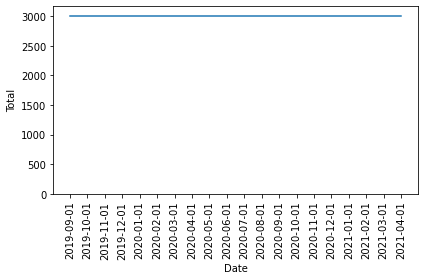

<Figure size 432x288 with 0 Axes>

In [10]:
plot_measures(total_df, title='', column_to_plot='doac', category=False, y_label='Total', interactive=False, filename="total")


### STP Breakdown

In [16]:
def calculate_rate(df, value_col, population_col, rate_per=1000):
    num_per_thousand = df[value_col]/(df[population_col]/rate_per)
    df['rate'] = num_per_thousand
    
df_stp = pd.read_csv('../output/measure_stp.csv')
df_stp['date'] = pd.to_datetime(df_stp['date'])
calculate_rate(df_stp, 'doac', 'population')
deciles_chart(df_stp, period_column='date', column='rate', title='Decile chart',ylabel='rate per 1000', interactive=False)
plt.tight_layout()
plt.savefig('../output/measure_stp.jpeg')

NameError: name 'charts' is not defined

### Breakdown by DOAC

In [20]:
df_doac_code = pd.read_csv('../output/measure_doac_code.csv')
df_doac_code['doac_code'] = df_doac_code['doac_code'].astype('float')

def plot_measures(df, title, column_to_plot, category=False, y_label='Rate per 1000', interactive=True):

    if interactive:

        fig = go.Figure()

        if category:
            for unique_category in df[category].unique():

                df_subset = df[df[category] == unique_category]
                fig.add_trace(go.Scatter(
                    x=df_subset['date'], y=df_subset[column_to_plot], name=str(unique_category)))

        else:
            fig.add_trace(go.Scatter(
                x=df['date'], y=df[column_to_plot]))

        # Set title
        fig.update_layout(
            title_text=title,
            hovermode='x',
            title_x=0.5,


        )

        fig.update_yaxes(title=y_label)
        fig.update_xaxes(title="Date")

        # Add range slider
        fig.update_layout(
            xaxis=go.layout.XAxis(
                rangeselector=dict(
                    buttons=list([
                        dict(count=1,
                            label="1m",
                            step="month",
                            stepmode="backward"),
                        dict(count=6,
                            label="6m",
                            step="month",
                            stepmode="backward"),

                        dict(count=1,
                            label="1y",
                            step="year",
                            stepmode="backward"),
                        dict(step="all")
                    ])
                ),
                rangeslider=dict(
                    visible=True
                ),
                type="date"
            )
        )

        fig.show()
        

    else:

        if category:
            for unique_category in df[category].unique():
                

                df_subset = df[df[category] == unique_category]

                plt.plot(df_subset['date'], df_subset[column_to_plot])
        else:
            plt.plot(df['date'], df[column_to_plot])

        plt.ylabel(y_label)
        plt.xlabel('Date')
        plt.xticks(rotation='vertical')
        plt.title(title)

        if category:
            plt.legend(df[category].unique(), bbox_to_anchor=(
                1.04, 1), loc="upper left")

        else:
            pass

        
        plt.show()
        plt.clf()
        


In [21]:
population_df = df_doac_code.groupby(by=['date'])[['population']].sum().reset_index()

In [22]:
def replace_population(row):
    
    row['population'] = population_df[population_df['date']==row['date']]['population'].values[0]
    return row

df_doac_code = df_doac_code.apply(lambda row: replace_population(row), axis=1)

In [23]:
calculate_rate(df_doac_code, 'doac', 'population')

Total use of each doac across study period.

In [24]:
codelist = pd.read_csv('../codelists/opensafely-direct-acting-oral-anticoagulants-doac.csv')


In [25]:
def get_term(row, code_column):
    
    row['term'] = codelist['chemical'][codelist['id'] == row[code_column]].values[0]
    
    return row


df_doac_code_count = df_doac_code.groupby(by='doac_code')[['doac']].sum().reset_index()

df_doac_code_count = df_doac_code_count.apply(lambda row: get_term(row, 'doac_code'),axis=1)


# other_count = 0
# def get_other_count(row, other_count):
#     count = row['doac']
#     if count<=5:
#         other_count+=count

# df_doac_code_count.apply(lambda row: get_other_count(row, other_count), axis=1)
# df_doac_code_count = df_doac_code_count[df_doac_code_count['doac']>5]      
# df_doac_code_count = df_doac_code_count.append(pd.DataFrame([['-', other_count, 'Other']], columns=['doac_code', 'doac', 'term']))
# df_doac_code_count



In [26]:
df_doac_code = df_doac_code.dropna()

df_doac_code = df_doac_code.apply(lambda row: get_term(row, 'doac_code'),axis=1)

In [27]:
df_doac_code = df_doac_code.groupby(by=['term', 'date'])['rate'].mean().reset_index()

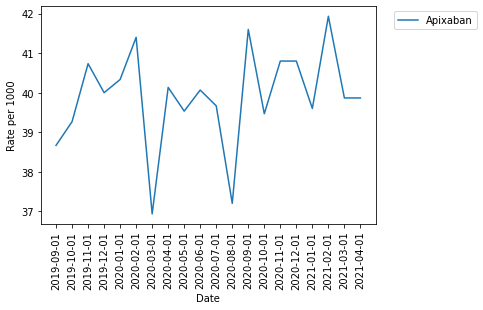

<Figure size 432x288 with 0 Axes>

In [28]:
plot_measures(df_doac_code, '', 'rate', category='term', y_label='Rate per 1000', interactive=False)


### Demographic breakdown

In [29]:
pd.options.mode.chained_assignment = None
from collections import Counter
demographic_df = pd.read_csv('../output/input_demographics.csv')
demographic_df_doac = demographic_df[(demographic_df['mechanical_valve']==1)&(demographic_df['doac']==1)]



demographics = ['sex', 'age_band', 'atrial_fib', 'imd', 'eth2001']
demographic_counts = {}

for dem in demographics:
    
    if dem == "imd":
        demographic_df_doac["imd"] = pd.qcut(demographic_df_doac["imd"], q=5,duplicates="drop")  
    column = demographic_df_doac[dem]
    count_dict = Counter(column.dropna())
    
    demographic_counts[dem] = count_dict


#### Sex

In [30]:
sex_dict = demographic_counts['sex']
sex_df = pd.DataFrame.from_dict(sex_dict, orient='index').rename(columns={'index': 'row', 0: 'count'})

total = sex_df['count'].sum()

# other_count = 0
# def get_other_count(row, other_count):
#     count = row['count']
#     if count<=5:
#         other_count+=count

# sex_df.apply(lambda row: get_other_count(row, other_count), axis=1)
# sex_df = sex_df[sex_df['count']>5]      

# if other_count >5:
#     sex_df = sex_df.append(pd.DataFrame([other_count], columns=['count']))


def calculate_percent(row, total):
    row['%'] = (row['count']/total)*100
    return row
sex_df = sex_df.apply(lambda row: calculate_percent(row, total), axis=1)


sex_df

,count,%
F,1232,51
M,1185,49
U,22,1


#### Ethnicity

In [31]:
ethnicity_dict = demographic_counts['eth2001']
ethnicity_df = pd.DataFrame.from_dict(ethnicity_dict, orient='index').rename(columns={'index': 'row', 0: 'count'})

total = ethnicity_df['count'].sum()

# other_count = 0
# def get_other_count(row, other_count):
#     count = row['count']
#     if count<=5:
#         other_count+=count

# ethnicity_df.apply(lambda row: get_other_count(row, other_count), axis=1)
# ethnicity_df = ethnicity_df[ethnicity_df['count']>5]      

# if other_count >5:
#     ethnicity_df = ethnicity_df.append(pd.DataFrame([other_count], columns=['count']))


def calculate_percent(row, total):
    row['%'] = (row['count']/total)*100
    return row
ethnicity_df = ethnicity_df.apply(lambda row: calculate_percent(row, total), axis=1)


ethnicity_df

,count,%
5,83,3
2,603,25
1,1212,50
7,18,1
4,157,6
3,306,13
6,39,2
8,21,1


#### IMD

In [32]:
imd_dict = demographic_counts['imd']
imd_df = pd.DataFrame.from_dict(imd_dict, orient='index').rename(columns={'index': 'row', 0: 'count'})

total = imd_df['count'].sum()

# other_count = 0
# def get_other_count(row, other_count):
#     count = row['count']
#     if count<=5:
#         other_count+=count

# imd_df.apply(lambda row: get_other_count(row, other_count), axis=1)
# imd_df = imd_df[imd_df['count']>5]      

# if other_count >5:
#     imd_df = imd_df.append(pd.DataFrame([other_count], columns=['count']))


def calculate_percent(row, total):
    row['%'] = (row['count']/total)*100
    return row
imd_df = imd_df.apply(lambda row: calculate_percent(row, total), axis=1)


imd_df

,count,%
"(12001.0, 18001.0]",103,21
"(0.999, 12001.0]",284,59
"(18001.0, 24001.0]",98,20


#### AF

In [33]:
af_dict = demographic_counts['atrial_fib']
af_df = pd.DataFrame.from_dict(af_dict, orient='index').rename(columns={'index': 'row', 0: 'count'})

total = af_df['count'].sum()

# other_count = 0
# def get_other_count(row, other_count):
#     count = row['count']
#     if count<=5:
#         other_count+=count

# af_df.apply(lambda row: get_other_count(row, other_count), axis=1)
# af_df = af_df[af_df['count']>5]      

# if other_count >5:
#     af_df = af_df.append(pd.DataFrame([other_count], columns=['count']))


def calculate_percent(row, total):
    row['%'] = (row['count']/total)*100
    return row
af_df = af_df.apply(lambda row: calculate_percent(row, total), axis=1)


af_df

,count,%
0,2424,99
1,15,1


#### Age Band

In [34]:
age_dict = demographic_counts['age_band']
age_df = pd.DataFrame.from_dict(age_dict, orient='index').rename(columns={'index': 'row', 0: 'count'})

total = age_df['count'].sum()

# other_count = 0
# def get_other_count(row, other_count):
#     count = row['count']
#     if count<=5:
#         other_count+=count

# age_df.apply(lambda row: get_other_count(row, other_count), axis=1)
# age_df = age_df[age_df['count']>5]      

# if other_count >5:
#     age_df = age_df.append(pd.DataFrame([other_count], columns=['count']))


def calculate_percent(row, total):
    row['%'] = (row['count']/total)*100
    return row
age_df = age_df.apply(lambda row: calculate_percent(row, total), axis=1)


age_df

,count,%
50-59,345,14
20-29,304,12
60-69,284,12
80+,284,12
0-19,293,12
40-49,313,13
30-39,304,12
70-79,309,13
0,3,0
